<a href="https://colab.research.google.com/github/lizmosquera/InteligenciaComputacional/blob/master/intento1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf_nightly-2.0-preview

ERROR: Could not find a version that satisfies the requirement tf_nightly-2.0-preview (from versions: none)
ERROR: No matching distribution found for tf_nightly-2.0-preview


In [0]:
#!pip install tensorflow==2.0.0b1

In [1]:
!pip install tensorflow==2.0.0

     |████████████████████████████████| 86.3MB 53kB/s 
     |████████████████████████████████| 3.8MB 44.7MB/s 
     |████████████████████████████████| 450kB 53.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=9eb010daae8bbd63fc883f78bf69a77da3b5fb9d5114b81a6fbc874122f0ce60
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation

In [2]:
import tensorflow as tf
print (tf.__version__)

2.0.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time,series,format="-",start=0,end=None):
  plt.plot(time[start:end],series[start:end],format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)


In [4]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-05-02 02:35:52--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 2a00:1450:4013:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-05-02 02:35:53 (98.5 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



In [5]:
#importar los datos

import csv
time_step = []
sunspots = []

#with open('Sunspots.csv') as csvfile:
with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
print('series: {}'.format(series[:5]))
print('time: {}'.format(time[:5]))

series: [ 96.7 104.3 116.7  92.8 141.7]
time: [0 1 2 3 4]


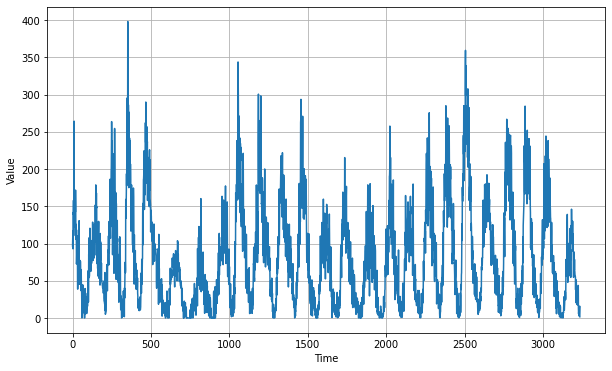

In [6]:
#explorar datos graficamente
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
#preparar el Dataset
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]


In [0]:
#función para escoger parte de los datos
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
shuffle_buffer_size = 1000
window_size = 60
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(x_train.shape)

(3000,)


In [10]:
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [12]:
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
30/30 [==============================] - 7s 241ms/step - loss: 31.7964 - mae: 32.4470
Epoch 2/50
30/30 [==============================] - 4s 139ms/step - loss: 23.2448 - mae: 23.7263
Epoch 3/50
30/30 [==============================] - 4s 137ms/step - loss: 20.9712 - mae: 21.4732
Epoch 4/50
30/30 [==============================] - 4s 139ms/step - loss: 19.9032 - mae: 20.4038
Epoch 5/50
30/30 [==============================] - 4s 138ms/step - loss: 19.9111 - mae: 20.4222
Epoch 6/50
30/30 [==============================] - 4s 136ms/step - loss: 19.6981 - mae: 20.1808
Epoch 7/50
30/30 [==============================] - 4s 138ms/step - loss: 18.6871 - mae: 19.1893
Epoch 8/50
30/30 [==============================] - 4s 137ms/step - loss: 18.6246 - mae: 19.1022
Epoch 9/50
30/30 [==============================] - 4s 138ms/step - loss: 18.4055 - mae: 18.9372
Epoch 10/50
30/30 [==============================] - 4s 138ms/step - loss: 18.3238 - mae: 18.8273
Epoch 11/50
30/30 [==========

In [34]:
#crear modelo
tf.keras.backend.clear_session()
window_size = 60
batch_size = 64
train_set = windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

model=tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60,kernel_size=5,strides=1, padding="causal",
                         activation="relu",input_shape=[None,1]), #1D convolution con 32 filtros                             
  tf.keras.layers.LSTM(32,return_sequences=True),#capa single LSTM de 32 celdas
  tf.keras.layers.LSTM(32,return_sequences=True),#capa LSTM con 32 celdas
  tf.keras.layers.Dense(30,activation="relu"),#Deep Neural Network
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1), #neurona de salida
  tf.keras.layers.Lambda(lambda x:x*400) #la capa lambda multiplica la x por 400
])

lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch:1e-8*10**(epoch/20))

optimizer=tf.keras.optimizers.SGD(lr=1e-7,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(train_set,epochs=60,callbacks=[lr_schedule])

Epoch 1/60
46/46 [==============================] - 7s 152ms/step - loss: 124.0090 - mae: 124.5081
Epoch 2/60
46/46 [==============================] - 4s 78ms/step - loss: 119.3725 - mae: 119.9881
Epoch 3/60
46/46 [==============================] - 4s 78ms/step - loss: 115.0792 - mae: 115.5246
Epoch 4/60
46/46 [==============================] - 4s 79ms/step - loss: 111.1948 - mae: 111.3501
Epoch 5/60
46/46 [==============================] - 4s 78ms/step - loss: 107.0648 - mae: 107.5593
Epoch 6/60
46/46 [==============================] - 4s 78ms/step - loss: 103.4830 - mae: 104.1000
Epoch 7/60
46/46 [==============================] - 4s 78ms/step - loss: 99.6227 - mae: 100.4443
Epoch 8/60
46/46 [==============================] - 4s 77ms/step - loss: 95.7629 - mae: 96.4528
Epoch 9/60
46/46 [==============================] - 4s 78ms/step - loss: 91.4062 - mae: 92.1809
Epoch 10/60
46/46 [==============================] - 4s 77ms/step - loss: 87.5541 - mae: 88.0158
Epoch 11/60
46/46 [======

ValueError: ignored

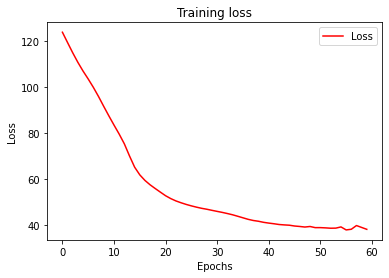

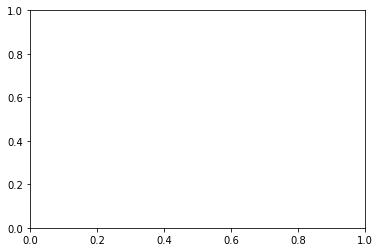

In [35]:

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']
epochs=range(len(loss)) # Get number of epochs
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])
plt.figure()


zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)
#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

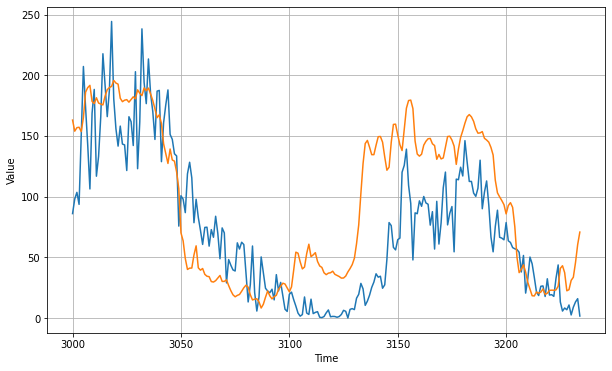

In [37]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
train_set = windowed_dataset(x_train,window_size=60,batch_size=250, shuffle_buffer_size)

model=tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60,kernel_size=5,strides=1, padding="causal",
                         activation="relu",input_shape=[None,1]), #1D convolution con 32 filtros                             
  tf.keras.layers.LSTM(32,return_sequences=True),#capa single LSTM de 32 celdas
  tf.keras.layers.LSTM(32,return_sequences=True),#capa LSTM con 32 celdas
  tf.keras.layers.Dense(30,activation="relu"),#Deep Neural Network
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1), #neurona de salida
  #tf.keras.layers.Dense(1), #neurona de salida
  tf.keras.layers.Lambda(lambda x:x*400) #la capa lambda multiplica la x por 400
])

optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(train_set,epochs=500)

SyntaxError: ignored

In [31]:
train_set = windowed_dataset(x_train,window_size=60,batch_size=250, shuffle_buffer_size)

model=tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32,kernel_size=5,strides=1, padding="causal",
                         activation="relu",input_shape=[None,1]), #1D convolution con 32 filtros                             
  tf.keras.layers.LSTM(60,return_sequences=True),#capa single LSTM de 32 celdas
  tf.keras.layers.LSTM(60,return_sequences=True),#capa LSTM con 32 celdas
  tf.keras.layers.Dense(30,activation="relu"),#Deep Neural Network
  tf.keras.layers.Dense(10,activation="relu"),
  tf.keras.layers.Dense(1), #neurona de salida
  #tf.keras.layers.Dense(1), #neurona de salida
  tf.keras.layers.Lambda(lambda x:x*400) #la capa lambda multiplica la x por 400
])

optimizer=tf.keras.optimizers.SGD(lr=1e-5,momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history=model.fit(train_set,epochs=500)

SyntaxError: ignored

In [38]:
forecast=[] #forecast Vs DAta
#results=[]
for time in range(len(series)-window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast=forecast[split_time-window_size:]
results=np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))

plot_series(time_valid, x_valid)
plot_series(time_valid,results)

ValueError: ignored

In [39]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

38.204918

In [0]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer): #crear un dataset
  series=tf.expand_dims(series, axis=-1) #create a dataset

  ds=tf.data.Dataset.from_tensor_slices(series)
  ds=ds.window(window_size+1,shift=1,drop_remainder=True)#to slice the data up into the appropriate windows
  ds=ds.flat_map(lambda w: w.batch(window_size+1))#flatten the data out flatened into chunksin the suze of our window_size+1
  ds=ds.shuffle(shuffle_buffer)
  ds=ds.map(lambda w:(w[:-1],w[-1])) #shuflet it, choosing smaller number speeds
 
  return ds.batch(batch_size).prefetch(1)#size parameter =2 corresponde Yb